# Assess thermodynamic fingerprints of 11ntR variants
Copyright 2023 John Shin under GPL-3.0

Supporting Figures come from this document.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as mcm
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
import matplotlib.markers as mmarkers
from matplotlib.gridspec import GridSpec
import seaborn as sns

from tqdm import tqdm
import re

import networkx as nx

from statsmodels.stats import multitest

In [2]:
def displayAllRows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.reset_option('max_rows')
    
def displayAllCols(df):
    pd.set_option('display.max_columns', None)
    display(df)
    pd.reset_option('max_columns')
    
def displayAllIndex(df):
    pd.set_option('display.multi_sparse', False)
    display(df)
    pd.reset_option('display.multi_sparse')
    
    
def revDict(d):
    return {v: k for k, v in d.items()}

In [3]:
def subtractWt(df,wt_df):
    '''subtracts the wt_df from df by scaffold'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    sub_df = df.copy()
    sub_df[bs_cols] = np.subtract(sub_df[bs_cols],np.tile(wt_df[bs_cols],(len(sub_df)//5,1)))
    
    return sub_df

In [4]:
def subtractdfs(df1,df2):
    '''subtracts df2 from df1 by index'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    sub_df = df1.copy()
    sub_df[bs_cols] = np.subtract(sub_df[bs_cols],df2[bs_cols])
    
    return sub_df

In [5]:
def findPercentiles(df,p=[0.5,0.025,0.975],p_names=['dG','dG_lb','dG_ub']):
    '''extracts the p percentile value from bs df'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    out_df = pd.DataFrame(index=df.index)
    out_df[p_names] = df[bs_cols].quantile(q=p,axis=1).T
    
    return out_df

In [6]:
def replaceLimits(df,limits):
    
    out_df = df.copy()
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
       
    out_df.loc[limits[limits].index,bs_cols] = -7.1
    
    return out_df

In [7]:
def findPercentilesOverScaffolds(df,p=[0.5,0.025,0.975],p_names=['dG','dG_lb','dG_ub']):
    '''extracts the p percentile value from bs df'''
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    
    out_df = pd.DataFrame(index=df.index.levels[0])
    
    g = df[bs_cols].groupby(
        'seq').agg(
        np.nanmean).quantile(
        q=p,axis=1).T.rename(
        columns={k:v for k,v in zip(p,p_names)})
    
    out_df = out_df.join(g)
    
    return out_df

In [8]:
def adj_pvals(df,p_col='p_val',a_col='adj_p_val',method='fdr_bh'):
    
    out_df = df.copy()
    temp_pvals = out_df[p_col]
    temp_corr_pvals = temp_pvals.copy()
    print(sum(~np.isnan(temp_pvals)),'p-values')
    _,temp_corr_pvals[~np.isnan(temp_pvals)],_,_ = multitest.multipletests(
        temp_pvals[~np.isnan(temp_pvals)],method=method)
    out_df[a_col] = temp_corr_pvals
    
    return out_df

In [9]:
nuc_palette = {'A':'tab:blue',
               'U':'tab:orange',
               'G':'tab:green',
               'C':'tab:red'}

# Import Data

Data with all the bootstrapped info

In [10]:
GAAA_wt_bs_df = pd.read_pickle('data/GAAA_wt_df.pkl')
GAAA_single_bs_df = pd.read_pickle('data/GAAA_single_df.pkl')
GAAA_double_bs_df = pd.read_pickle('data/GAAA_double_df.pkl')
GAAA_double_bs_df.index.names = ['seq','scaffold']

In [11]:
GUAA_wt_bs_df = pd.read_pickle('data/GUAA_wt_df.pkl')
GUAA_single_bs_df = pd.read_pickle('data/GUAA_single_df.pkl')
GUAA_double_bs_df = pd.read_pickle('data/GUAA_double_df.pkl')
GUAA_double_bs_df.index.names = ['seq','scaffold']

Metadata

In [12]:
sequence_11ntRwt = GUAA_wt_bs_df.index[0][0]
mutation_dict_11ntR = {
    0:7, 1:8, 2:9, 3:10, 4:11, 5:1, 6:2, 7:3, 8:4, 9:5, 10:6, 
}
layout_11ntR = {
    1:[5,10],
    2:[6,8],
    3:[5.5,6],
    4:[3,4],
    5:[6,4],
    6:[5,2],
    7:[2,2],
    8:[2.5,6],
    9:[1,7],
    10:[3,8],
    11:[2,10]
}
base_pairs_11ntR = [[11,1],[10,2],[9,0],[8,3],[4,5],[7,6]]
base_pair_plot_dict = {
    1:1,11:1,
    2:2,10:2,
    9:3,
    3:4,8:4,
    4:5,5:5,
    6:6,7:6
}

In [13]:
wt_meta_df = GAAA_wt_bs_df[[]].copy()
single_meta_df = GAAA_single_bs_df[['first_loc','first_res','second_loc','second_res']].copy()
double_meta_df = GAAA_double_bs_df[['first_loc','first_res','second_loc','second_res']].copy()

In [14]:
# single_meta_df.to_pickle('data/single_meta.pkl')
# double_meta_df.to_pickle('data/double_meta.pkl')

Median and ci data

In [15]:
dG_GAAA_wt_df = findPercentiles(GAAA_wt_bs_df)
dG_GAAA_single_df = pd.concat((single_meta_df,findPercentiles(GAAA_single_bs_df)),axis=1)
dG_GAAA_double_df = pd.concat((double_meta_df,findPercentiles(GAAA_double_bs_df)),axis=1)

In [16]:
dG_GUAA_wt_df = findPercentiles(GUAA_wt_bs_df)
dG_GUAA_single_df = pd.concat((single_meta_df,findPercentiles(GUAA_single_bs_df)),axis=1)
dG_GUAA_double_df = pd.concat((double_meta_df,findPercentiles(GUAA_double_bs_df)),axis=1)

In [17]:
for df in [dG_GAAA_wt_df,dG_GAAA_single_df,dG_GAAA_double_df,
           dG_GUAA_wt_df,dG_GUAA_single_df,dG_GUAA_double_df]:
    df['limit'] = df['dG'] >= -7.1
    df.loc[df['limit'],'dG'] = -7.1

In [18]:
GAAA_ddG_limit = -7.1 - np.mean(dG_GAAA_wt_df['dG'])
GUAA_ddG_limit = -7.1 - np.mean(dG_GUAA_wt_df['dG'])

In [19]:
avg_dG_GAAA_wt_df = findPercentilesOverScaffolds(GAAA_wt_bs_df)

avg_dG_GAAA_single_df = pd.concat((single_meta_df.groupby('seq').first(),
                                findPercentilesOverScaffolds(
                                    replaceLimits(
                                        GAAA_single_bs_df,
                                        limits=dG_GAAA_single_df['limit']
                                    )
                                )),axis=1)

avg_dG_GAAA_double_df = pd.concat((double_meta_df.groupby('seq').first(),
                                findPercentilesOverScaffolds(
                                    replaceLimits(
                                        GAAA_double_bs_df,
                                        limits=dG_GAAA_double_df['limit']
                                    )
                                )),axis=1)

In [20]:
avg_dG_GUAA_wt_df = findPercentilesOverScaffolds(GUAA_wt_bs_df)

avg_dG_GUAA_single_df = pd.concat((single_meta_df.groupby('seq').first(),
                                findPercentilesOverScaffolds(
                                    replaceLimits(
                                        GUAA_single_bs_df,
                                        limits=dG_GUAA_single_df['limit']
                                    )
                                )),axis=1)

avg_dG_GUAA_double_df = pd.concat((double_meta_df.groupby('seq').first(),
                                findPercentilesOverScaffolds(
                                    replaceLimits(
                                        GUAA_double_bs_df,
                                        limits=dG_GUAA_double_df['limit']
                                    )
                                )),axis=1)

In [21]:
for df,avg_df in zip([dG_GAAA_single_df,dG_GAAA_double_df,
                       dG_GUAA_single_df,dG_GUAA_double_df],
                  [avg_dG_GAAA_single_df,avg_dG_GAAA_double_df
                   ,avg_dG_GUAA_single_df,avg_dG_GUAA_double_df]):
    avg_df['limit'] = df.groupby('seq')['limit'].any()

In [22]:
avg_dG_GAAA_all_df = pd.concat((avg_dG_GAAA_single_df,avg_dG_GAAA_double_df))
avg_dG_GUAA_all_df = pd.concat((avg_dG_GUAA_wt_df,avg_dG_GUAA_single_df,avg_dG_GUAA_double_df))


### Scaffold Effects

In [23]:
def getVars(X,y):
    '''calculate correlation coefficient between rows of X and y
    y could be a row vector or matrix Y with same shape as X, 
        upon which row-by-row correlations will be calculated'''
    
    X_shape = X.shape
    
    if len(y.shape) == 1:
        Y = np.tile(y,(X.shape[0],1))
    else:
        Y = y
            
    if np.sum(np.sum(np.isnan(X))) > 0:
        Y[np.isnan(X)] = np.NaN
    
    Var = np.var(X - Y,axis=1)
    Var[np.sum(np.isnan(X),axis=1)>2] = np.NaN
    
    return Var
    

In [24]:
def testScaffoldEffectCorrelation(mut_df,wt_df,out_df,
                                   verbose=False,
                                   bs_cols = [f"bs_{i}" for i in range(10000)],
                                   n_sc = 5,threshold=0):
    
    out_df = out_df.copy()
    
    # Set some parameters
    n_bs = len(bs_cols)
    n_conds = int(len(mut_df)/n_sc)
    
    # Generate nulls, i.e. permute wt data and calculate correlation of ddGs with itself
    #   and generate test stats, i.e. calculate correlation of ddG between mut and wt    
    wt_bs = wt_df[bs_cols].values
    
    # Shuffle wt data to make null distribution for comparison
    shuffled_wt = wt_bs.copy()
    shuffled_cols = np.roll(np.arange(shuffled_wt.shape[1]),1)
    shuffled_wt = shuffled_wt[:,shuffled_cols]
            
    Vars = np.empty((n_conds,n_bs))
    null_Vars = np.empty((n_conds,n_bs))
    
    num_scaffolds = np.empty(n_conds)
    
    for i,seq in enumerate(tqdm(out_df.index)):
        # mask out values that are missing

        temp_df = mut_df.loc[seq,bs_cols]
        
        temp_df[np.nanmedian(temp_df,axis=1)>=-7.1] = np.NaN
        
        mask = np.any(temp_df.isna(),axis=1).values
                
        masked_data = temp_df.values[~mask]
        masked_wt = wt_bs[~mask]
        masked_shuffled_wt = shuffled_wt[~mask]
        
        if sum(mask) > 2:
            Vars[i,:] = np.NaN
            null_Vars[i,:] = np.NaN
            limit=True
        else:            
            Vars[i,:] = getVars(masked_data.T, masked_wt.T)
            null_Vars[i,:] = getVars(masked_shuffled_wt.T, masked_wt.T)
            
        num_scaffolds[i] = 5-sum(mask)
                
    # Record average test stat per construct
    out_df[['0.05_var','median_var','0.95_var']] = np.quantile(Vars,
                                                          q=[0.05,0.5,0.95],
                                                          axis=1).T

    # Tabulate p values for observed stat w/in each scaffold for a given construct   
    out_df['p_val_var'] = np.mean(Vars <= null_Vars, axis=1)
    out_df.loc[np.any(np.isnan(Vars),axis=1),'p_val_var'] = np.NaN

    
    # Record how many non NaN values were used in calculating scaffold effects
    out_df['n'] = num_scaffolds
    
    if verbose:
        return out_df,nulls,tests
    else:
        return out_df

In [25]:
def plotFingerprints(seq1,seq2,
                     bs_df_1,bs_df_2,
                     colors=['tab:blue','k'],
                     axs=None):
    
    
    if axs is None:
        fig,axs = plt.subplots(nrows=2, sharex=True)
    
    x = np.arange(5)+1
    
    dG_1 = findPercentiles(bs_df_1)
    dG_2 = findPercentiles(bs_df_2)
    ddG = findPercentiles(subtractWt(bs_df_1,bs_df_2))
    
    limit_mask = np.any(np.array([dG_1['dG']>=-7.1,dG_2['dG']>=-7.1]),axis=0)
    nan_mask = np.any(np.array([np.any(dG_1.isna(),axis=1),np.any(dG_2.isna(),axis=1)]),axis=0)
    
    mask = np.any(np.array([limit_mask,nan_mask]),axis=0)
    
    dG_1 = dG_1.loc[~mask,:]
    dG_2 = dG_2.loc[~mask,:]
    ddG = ddG.loc[~mask,:]
    x = x[~mask]
    
    axs[0].errorbar(x,dG_1['dG'],
                    yerr = [dG_1['dG_ub']-dG_1['dG'],
                            dG_1['dG']-dG_1['dG_lb']],
                    fmt='o-', capsize=5,color=colors[0])
    
    axs[0].errorbar(x,dG_2['dG'],
                    yerr = [dG_2['dG_ub']-dG_2['dG'],
                            dG_2['dG']-dG_2['dG_lb']],
                    fmt='o-', capsize=5,color=colors[1])
    
    axs[1].errorbar(x,ddG['dG'],
                    yerr = [ddG['dG_ub']-ddG['dG'],
                            ddG['dG']-ddG['dG_lb']],
                    fmt='o-', capsize=5,color=colors[0])    
    
    axs[1].set_xticks(np.arange(5)+1)
    
    axs[1].set_xlabel('Scaffold')
    axs[1].set_ylabel(r'$\Delta\Delta G$ (kcal/mol)')
    axs[0].set_ylabel(r'$\Delta G$ (kcal/mol)')
    
    if axs is None:
        plt.show()
    

In [26]:
def pltVars(seq,df,colors=['tab:blue','k'],labels=['Variant','Expected from WT'],ax=None):
    
    bs_cols = [f"bs_{i}" for i in range(10000)]
    temp_df = df.loc[seq,bs_cols]
    wt_bs = GAAA_wt_bs_df[bs_cols].values
    shuffled_wt = wt_bs.copy()
    shuffled_cols = np.roll(np.arange(shuffled_wt.shape[1]),1)
    shuffled_wt = shuffled_wt[:,shuffled_cols]


    temp_df[np.nanmedian(temp_df,axis=1)>=-7.1] = np.NaN

    mask = np.any(temp_df.isna(),axis=1).values

    masked_data = temp_df.values[~mask]
    masked_wt = wt_bs[~mask]
    masked_shuffled_wt = shuffled_wt[~mask]
    foo = getVars(masked_data.T, masked_wt.T)
    bar = getVars(masked_shuffled_wt.T, masked_wt.T)

    if ax is None:
        fig,ax = plt.subplots()
        
    ax.hist(foo,histtype='step',label=labels[0],color=colors[0])
    ax.hist(bar,histtype='step',label=labels[1],color=colors[1])
    
    ax.legend()
    
    ax.set_title(seq)

    if ax is None:
        plt.show()

# GAAA Scaffold Effects

In [27]:
GAAA_single_se_pvals = testScaffoldEffectCorrelation(GAAA_single_bs_df,
                                                     GAAA_wt_bs_df,
                                                     avg_dG_GAAA_single_df.iloc[:,np.r_[:4,-1]],
                                                     threshold=0.3)
GAAA_double_se_pvals = testScaffoldEffectCorrelation(GAAA_double_bs_df,
                                                     GAAA_wt_bs_df,
                                                     avg_dG_GAAA_double_df.iloc[:,np.r_[:4,-1]],
                                                     threshold=0.3)

  0%|                                                                                                          | 0/33 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 495/495 [00:40<00:00, 12.09it/s]


In [28]:
GAAA_combined_pvals = pd.concat((GAAA_single_se_pvals,GAAA_double_se_pvals))
GAAA_combined_pvals = avg_dG_GAAA_all_df.join(GAAA_combined_pvals,lsuffix='left',how='right')
GAAA_combined_pvals = adj_pvals(GAAA_combined_pvals,
                                    p_col=f"p_val_var",
                                    a_col = f"adj_p_val_var")
    
GAAA_combined_pvals[f"nlogp_var"] = -np.log10(GAAA_combined_pvals[f"adj_p_val_var"]+1e-5)    


293 p-values


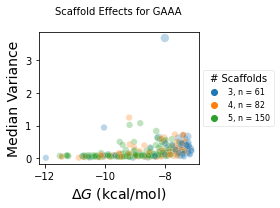

In [29]:
fig,ax = plt.subplots(facecolor='w',figsize=(4,3))


sns.scatterplot(data=GAAA_combined_pvals.query('adj_p_val_var >= 0.05'),x='dG',y='median_var',
                hue='n',hue_order=[3,4,5],ax=ax,palette=['tab:blue','tab:orange','tab:green'],size='nlogp_var',
               legend=False,alpha=0.3,size_norm=(0,1))

sns.scatterplot(data=GAAA_combined_pvals.query('adj_p_val_var < 0.05'),x='dG',y='median_var',
                hue='n',hue_order=[3,4,5],ax=ax,palette=['tab:blue','tab:orange','tab:green'],size='nlogp_var',
               legend=False,alpha=1,size_norm=(0,1))


ax.plot([],[],'o',color='tab:blue',label='3, n = 61')
ax.plot([],[],'o',color='tab:orange',label='4, n = 82')
ax.plot([],[],'o',color='tab:green',label='5, n = 150')

ax.set_ylabel(r'Median Variance',fontsize=14)
ax.set_xlabel(r'$\Delta G$ (kcal/mol)',fontsize=14)
ax.legend(fontsize=8,title='# Scaffolds',framealpha=0.4,loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Scaffold Effects for GAAA\n',fontsize=10)

plt.tight_layout()

plt.savefig('Figures/Supplement/GAAA_scaffold.png',facecolor='white',dpi=600)

plt.show()

In [30]:
GAAA_combined_pvals['n'].value_counts()

5.0    150
0.0    118
4.0     82
3.0     61
2.0     59
1.0     58
Name: n, dtype: int64

## GUAA

In [31]:
GUAA_wt_se_pvals = testScaffoldEffectCorrelation(GUAA_wt_bs_df,
                                                 GAAA_wt_bs_df,
                                                 avg_dG_GUAA_wt_df.iloc[:,:0])
GUAA_single_se_pvals = testScaffoldEffectCorrelation(GUAA_single_bs_df,
                                                     GAAA_wt_bs_df,
                                                     avg_dG_GUAA_single_df.iloc[:,np.r_[:4,-1]])
GUAA_double_se_pvals = testScaffoldEffectCorrelation(GUAA_double_bs_df,
                                                     GAAA_wt_bs_df,
                                                     avg_dG_GUAA_double_df.iloc[:,np.r_[:4,-1]])

  0%|                                                                                                          | 0/33 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
100%|███████████████████████████████████████████████████████████████████████████████████████████████| 495/495 [00:37<00:00, 13.33it/s]


In [32]:
GUAA_combined_pvals = pd.concat((GUAA_wt_se_pvals,GUAA_single_se_pvals,GUAA_double_se_pvals))
GUAA_combined_pvals = avg_dG_GUAA_all_df.join(GUAA_combined_pvals,lsuffix='left',how='right')

GUAA_combined_pvals['limit'] = GUAA_combined_pvals['limit'].astype(bool)

GUAA_combined_pvals = adj_pvals(GUAA_combined_pvals,
                                    p_col=f"p_val_var",
                                    a_col = f"adj_p_val_var")
    
GUAA_combined_pvals[f"nlogp_var"] = -np.log10(GUAA_combined_pvals[f"adj_p_val_var"]+1e-5)    


238 p-values


In [33]:
GUAA_combined_pvals['n'].value_counts()

0.0    132
1.0     91
4.0     88
3.0     77
5.0     73
2.0     68
Name: n, dtype: int64

In [34]:
GUAA_combined_pvals.query('(adj_p_val_var < 0.05)')

,dG,dG_lb,dG_ub,first_locleft,first_resleft,second_locleft,second_resleft,limitleft,0.05_var,median_var,0.95_var,p_val_var,n,first_loc,first_res,second_loc,second_res,limit,adj_p_val_var,nlogp_var
seq,,,,,,,,,,,,,,,,,,,,
UUUGG_CCUAAG,-8.082610,-8.234375,-7.931497,8.0,U,NaN,NaN,False,0.429140,0.635786,0.882335,0.0003,3.0,8.0,U,NaN,NaN,False,0.007933,2.099997
AAUGG_CCUGAG,-7.880246,-8.109714,-7.673142,7.0,A,4.0,G,False,0.259565,0.541874,0.879165,0.0024,4.0,7.0,A,4.0,G,False,0.027200,1.565271
CAUGG_CCCAAG,-7.661148,-8.072560,-7.393760,7.0,C,3.0,C,False,0.190531,0.402285,0.692312,0.0033,3.0,7.0,C,3.0,C,False,0.034148,1.466510
CAUGG_CCUACG,-8.102398,-8.342931,-7.936836,7.0,C,5.0,C,False,0.398224,0.594881,0.925338,0.0000,3.0,7.0,C,5.0,C,False,0.000000,5.000000
GAAGG_CCUAAG,-8.067047,-8.404907,-7.736011,7.0,G,9.0,A,False,0.585615,0.979564,1.770834,0.0007,4.0,7.0,G,9.0,A,False,0.015867,1.799241
GAUGG_CCCAAG,-8.052844,-8.184042,-7.938880,7.0,G,3.0,C,False,0.727015,0.949101,1.234243,0.0003,4.0,7.0,G,3.0,C,False,0.007933,2.099997
GAUGG_CCUAAA,-7.910030,-8.201719,-7.612669,7.0,G,6.0,A,False,0.232619,0.477920,0.815888,0.0036,4.0,7.0,G,6.0,A,False,0.035700,1.447210
GAUGG_CCUAGG,-7.798525,-7.965565,-7.634277,7.0,G,5.0,G,False,0.434884,0.619593,0.855753,0.0015,4.0,7.0,G,5.0,G,False,0.019040,1.720105
UAAGG_CCUAAU,-7.574488,-7.849846,-7.370796,9.0,A,6.0,U,False,0.477860,0.717773,0.990722,0.0015,3.0,9.0,A,6.0,U,False,0.019040,1.720105


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\nanfunctions

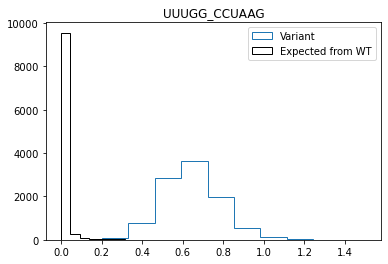

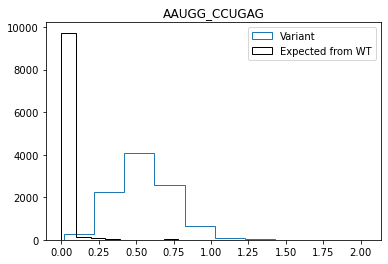

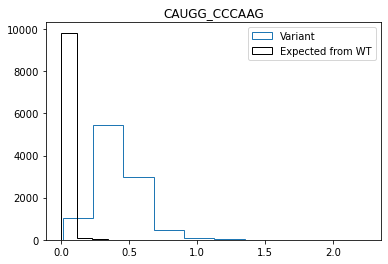

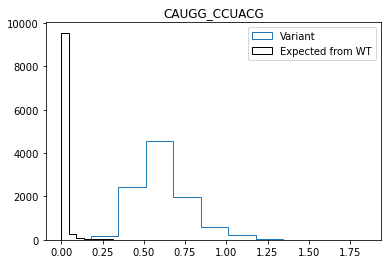

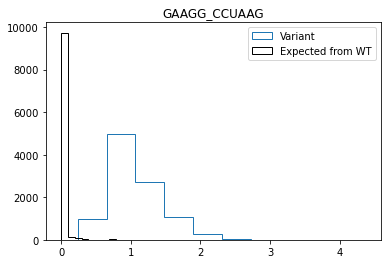

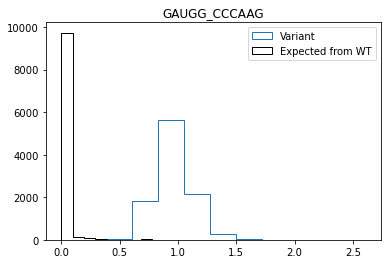

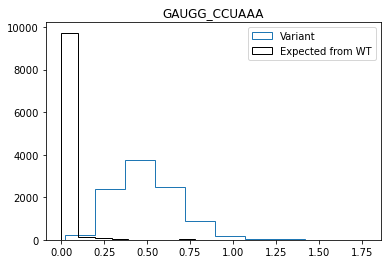

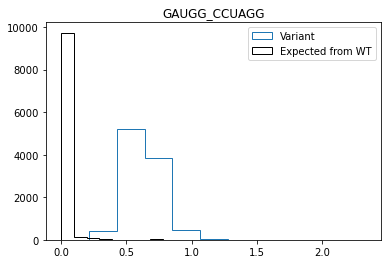

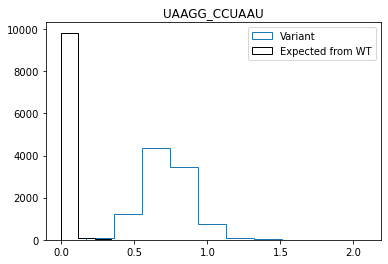

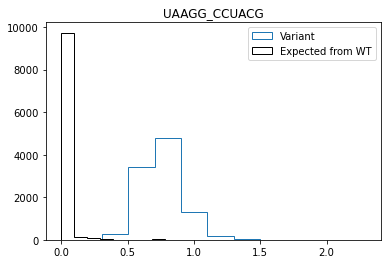

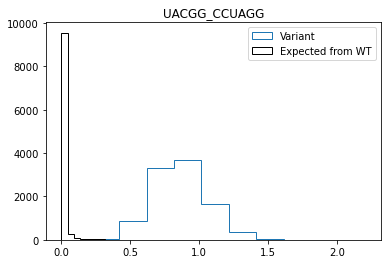

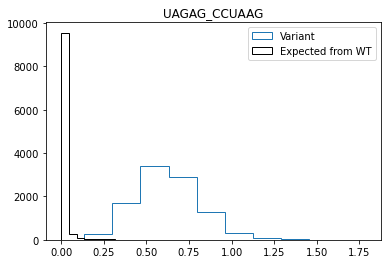

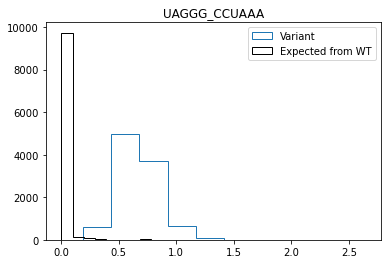

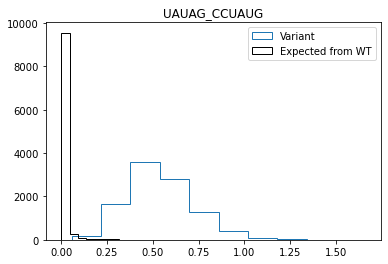

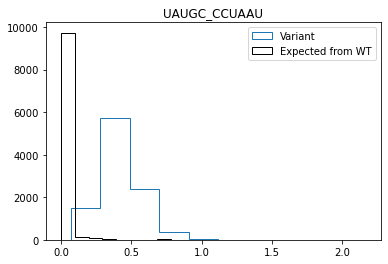

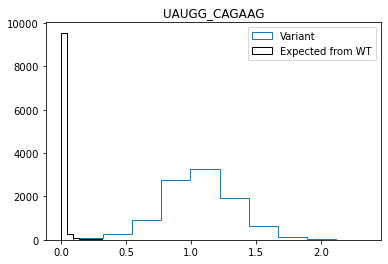

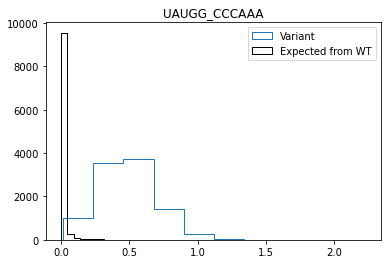

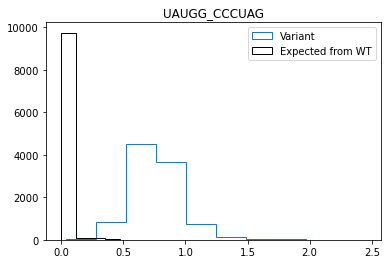

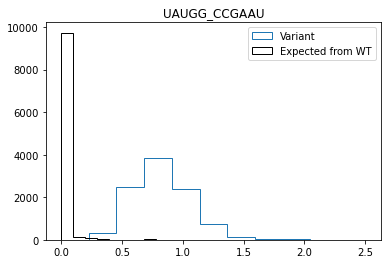

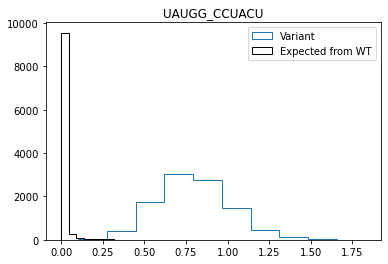

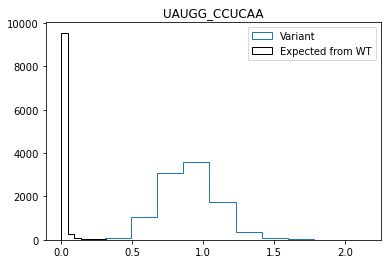

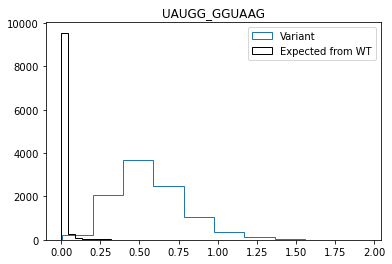

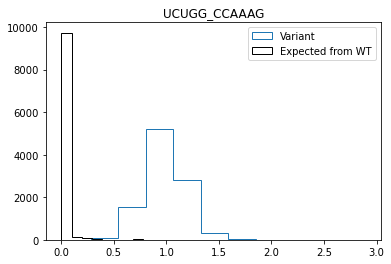

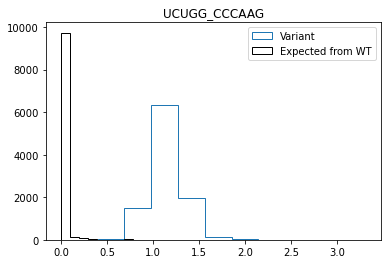

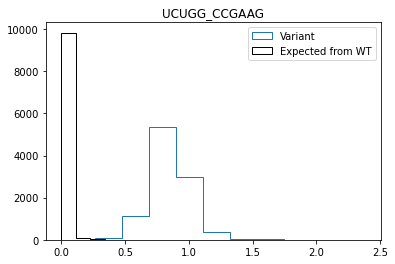

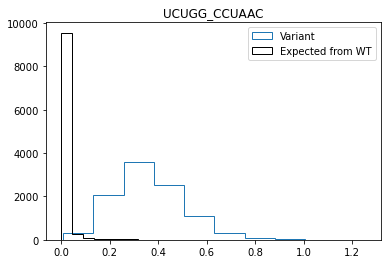

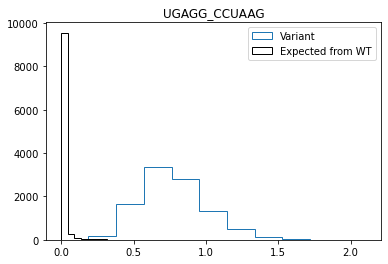

In [35]:
for row in GUAA_combined_pvals.query('(adj_p_val_var < 0.05)').iterrows():
    seq = row[0]
    
    if np.isnan(row[1]['second_loc']):
        pltVars(seq,GUAA_single_bs_df)
    else:
        pltVars(seq,GUAA_double_bs_df)
    

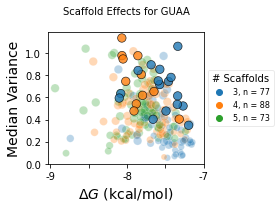

In [36]:
fig,ax = plt.subplots(facecolor='w',figsize=(4,3))

sns.scatterplot(data=GUAA_combined_pvals.query('adj_p_val_var >= 0.05'),x='dG',y='median_var',
                hue='n',hue_order=[3,4,5],ax=ax,palette=['tab:blue','tab:orange','tab:green'],size='nlogp_var',
               legend=False,alpha=0.3,size_norm=(0,1))

sns.scatterplot(data=GUAA_combined_pvals.query('adj_p_val_var < 0.05'),x='dG',y='median_var',
                hue='n',hue_order=[3,4,5],ax=ax,palette=['tab:blue','tab:orange','tab:green'],size='nlogp_var',
               legend=False,alpha=.8,size_norm=(0,1),edgecolor='k')


ax.plot([],[],'o',color='tab:blue',label='3, n = 77')
ax.plot([],[],'o',color='tab:orange',label='4, n = 88')
ax.plot([],[],'o',color='tab:green',label='5, n = 73')

ax.set_xticks([-9,-8.5,-8,-7.5,-7])
ax.set_xticklabels([-9,'',-8,'',-7])

# ax.set_yticks([-1,-0.5,0,0.5,1])

ax.set_ylabel(r'Median Variance',fontsize=14)
ax.set_xlabel(r'$\Delta G$ (kcal/mol)',fontsize=14)
ax.legend(fontsize=8,title='# Scaffolds',framealpha=0.4,loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Scaffold Effects for GUAA\n',fontsize=10)

plt.tight_layout()

plt.savefig('Figures/Supplement/GUAA_scaffold.png',facecolor='white',dpi=600)

plt.show()

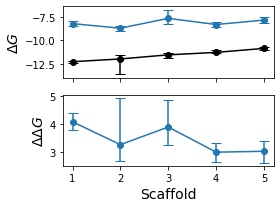

In [37]:
fig,axs = plt.subplots(nrows=2,sharex=True,figsize=(4,3))

plotFingerprints('UAUGG_CCUAAG','UAUGG_CCUAAG',
                 GUAA_wt_bs_df.loc['UAUGG_CCUAAG'],
                 GAAA_wt_bs_df.loc['UAUGG_CCUAAG'],
                 axs = axs)

axs[0].set_ylabel(r'$\Delta G$',fontsize=14)
axs[1].set_ylabel(r'$\Delta\Delta G$',fontsize=14)
axs[1].set_xlabel(axs[1].get_xlabel(),fontsize=14)

plt.tight_layout()
plt.savefig('Figures/Supplement/GUAA_fingerprints.png',facecolor='white',dpi=600)

plt.show()


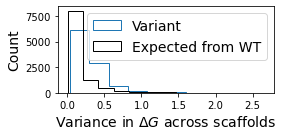

In [38]:
fig,ax = plt.subplots(figsize=(4,2))

pltVars('UAUGG_CCUAAG',GUAA_wt_bs_df,ax=ax)

ax.set_xlabel('Variance in $\Delta G$ across scaffolds', fontsize=14)
ax.set_ylabel('Count', fontsize=14)

ax.legend(fontsize=14)
ax.set_title('')
plt.tight_layout()

plt.savefig('Figures/Supplement/GUAA_variance.png',facecolor='white',dpi=600)

plt.show()

In [39]:
def fillHeatmap(df):
    
    colnames = df.columns.names
    indexcolumns = set(df.index)|set(df.columns)
    df[list(indexcolumns-set(df.columns))]=np.NaN
    df = pd.concat([df,pd.DataFrame(index=list(indexcolumns-set(df.index)))])
    df.columns.names = colnames
    
    return df

In [40]:
heatmap_df = GUAA_combined_pvals.copy()
heatmap_df['Significant'] = heatmap_df['adj_p_val_var'] < 0.05
heatmap_df.loc[heatmap_df['n'] < 3,'Significant'] = 'Limit'
heatmap_df = pd.pivot_table(heatmap_df,
               columns=['second_loc','second_res'],
               index=['first_loc','first_res'],
               values='Significant',aggfunc=lambda s:s)

heatmap_df = fillHeatmap(heatmap_df)
heatmap_df = heatmap_df.sort_values(by=['second_loc','second_res'],axis=1).sort_values('first_loc',axis=0)


In [41]:
for row in heatmap_df.iterrows():
    for col in row[1].iteritems():
        if pd.isna(col[1]):
            heatmap_df.loc[row[0],col[0]] = heatmap_df.loc[col[0],row[0]]

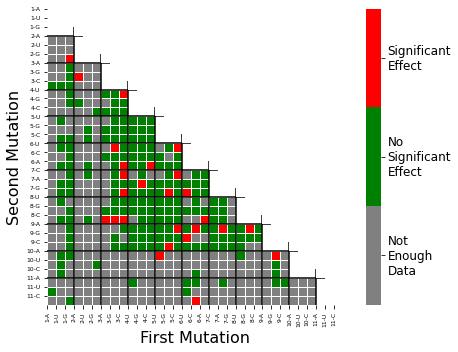

In [42]:
fig,ax = plt.subplots(figsize=(7,5))

mask = np.triu(np.ones_like(np.zeros((11*3,11*3)), dtype=bool))
# mask[mask==1] = np.NaN


vmax = 1

sns.heatmap(heatmap_df.replace({k:v for v,k in enumerate(['Limit',False,True])}),
            cmap=['grey','green','red'],mask=mask,
           linecolor='white',linewidth=0.5)


mask = np.tril(np.ones(33))
mask[mask==1] = np.NaN
sns.heatmap(mask,cbar=False,cmap='Greys',zorder=10)

ax.set_aspect(1)

ax.hlines(np.arange(1,11)*3,*ax.get_xlim(),'k')
ax.vlines(np.arange(1,11)*3,*ax.get_ylim(),'k')

ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels(),rotation=0,fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=14)


ax.set_yticks(np.arange(33))
ax.set_xticks(np.arange(33))
ax.set_yticklabels([f"{int(idx[0])}-{idx[1]}" for idx in list(heatmap_df.index)],fontsize=6)
ax.set_xticklabels([f"{int(idx[0])}-{idx[1]}" for idx in list(heatmap_df.index)],fontsize=6)


ax.collections[0].colorbar.set_label('')
ax.collections[0].colorbar.set_ticks([0.333,1,1.666])
ax.collections[0].colorbar.set_ticklabels(['Not\nEnough\nData','No\nSignificant\nEffect','Significant\nEffect'],
                                         rotation=0,fontsize=12,va='center')


ax.set_xlabel('First Mutation',fontsize=16)
ax.set_ylabel('Second Mutation',fontsize=16)

plt.tight_layout()

plt.savefig('Figures/Supplement/GUAA_scaffold_heatmap.png',facecolor='white',dpi=600)

plt.show()